In [1]:
import sys
import os
import math
import random
import heapq 
import time
import copy
import gc
import datetime
import numpy as np
import pandas as pd
import csv
import shutil
from functools import reduce
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import pdist
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,auc 
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import faiss 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import baostock as bs#pip install baostock
import mplfinance as mpf #pip install mplfinance
from matplotlib.pylab import date2num
import tushare as ts # pip install tushare
tstoken='2621bdfffbde695d0d256a69a71d9344c94c1d8a58f389cd391ceeeb' #youer token
ts.set_token(tstoken)
pro = ts.pro_api()
torch.cuda.set_device(6)
print (torch.cuda.current_device())

Loading faiss with AVX2 support.


6


In [30]:
root_dir = '/data/fjsdata/qtsys/img/' #the path of images
data = pd.read_csv('/data/fjsdata/qtsys/label.csv') 
print(data.shape)
#name = []
#for idx, row in data.iterrows():
#    if '20200327' in row['name']:
#        if os.path.exists(root_dir+row['name']):
#            shutil.copyfile( root_dir+row['name'], '/data/tmpexec/qtsysimg0327/'+row['name'])  
#            name.append(row['name'])
#print(len(name))

#data['flag'] = data['flag'].fillna('Y')
#data.to_csv('/data/fjsdata/qtsys/label.csv',index=False)
#data_n = data[data['flag']=='N']
#data_y = data[data['flag']=='Y']
#print(data_n.shape)
#print(data_y.shape)
#for idx, row in data_n.iterrows():
#    os.remove(root_dir+row['name']) #remove file
#data_y.to_csv('/data/fjsdata/qtsys/label.csv',index=False)

#for idx, row in data.iterrows():
#    if '20200327' in row['name']:
#        if os.path.exists(root_dir+row['name']):
#            os.remove(root_dir+row['name']) #remove file
#        data = data.drop(idx)
#print(data.shape)
#data.to_csv('/data/fjsdata/qtsys/label.csv',index=False)

(806, 3)


In [25]:
#define model: ATH
class SpatialAttention(nn.Module):#spatial attention layer
    def __init__(self):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size=3, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.downsample_layer = None
        self.do_downsample = False
        if in_channels != out_channels or stride != 1:
            self.do_downsample = True
            self.downsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.do_downsample:
            identity = self.downsample_layer(x)

        return F.relu(out + identity, inplace=True) #resnet

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class ATHNet(nn.Module):
    def __init__(self, code_size: int):
        super().__init__()
        #resnet and maxpool
        self.net1 = nn.Sequential(#(3,256,256)->(16,128,128)
            ResBlock(in_channels=3, out_channels=16, stride=2), 
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1)
        )
        
        #Attention (16,128,128)->(16,128,128)
        self.sa = SpatialAttention()
        
        #resnet and meanpool
        self.net2 =nn.Sequential( #(16,128,128)->(8,64,64)
            ResBlock(in_channels=16, out_channels=8, stride=2),
            nn.AvgPool2d(kernel_size=3, padding=1, stride=1)
        ) 
         
        #fully connected with conv (8,64,64)->(1,32,32)
        self.dense=ResBlock(in_channels=8, out_channels=1, stride=2)
        #fully connected (1,32,32)->class_size
        self.linear = nn.Linear(1*32*32, code_size)
    
        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        x = self.net1(x)
        x = self.sa(x)*x
        x = self.net2(x)
        x = self.dense(x)
        x = x.view(x.size(0),-1)
        x = self.linear(x)
        return x

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)

#define loss function:pairwise loss            
class PairwiseLoss(nn.Module):
    def __init__(self, margin=0.5, alpha=0.01):
        super(PairwiseLoss, self).__init__()
        self.alpha = alpha #regularization
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
        self.l1_loss = nn.L1Loss(reduction='mean')
    
    def forward(self,h1,h2,y):    
        margin_val = self.margin * h1.shape[1]
        squared_loss = torch.mean(self.mse_loss(h1, h2), dim=1)
        # T1: 0.5 * (1 - y) * dist(x1, x2)
        positive_pair_loss = (0.5 * (1 - y) * squared_loss)
        mean_positive_pair_loss = torch.mean(positive_pair_loss)
        # T2: 0.5 * y * max(margin - dist(x1, x2), 0)
        zeros = torch.zeros_like(squared_loss)
        marginMat = margin_val * torch.ones_like(squared_loss)
        negative_pair_loss = 0.5 * y * torch.max(zeros, marginMat - squared_loss)
        mean_negative_pair_loss = torch.mean(negative_pair_loss)

        # T3: alpha(dst_l1(abs(x1), 1)) + dist_l1(abs(x2), 1)))
        mean_value_regularization = self.alpha * (
                self.l1_loss(torch.abs(h1), torch.ones_like(h1)) +
                self.l1_loss(torch.abs(h2), torch.ones_like(h2)))

        loss = mean_positive_pair_loss + mean_negative_pair_loss + mean_value_regularization
        return loss

In [26]:
#Generate Dataset
root_dir = '/data/fjsdata/qtsys/img/' #the path of images
data = pd.read_csv('/data/fjsdata/qtsys/label.csv') 
data = data.drop_duplicates()
data = data.sample(frac=1).reset_index(drop=True) #shuffle
#Dataset
trN,trI, trY =[], [],[]
for _, row in data.iterrows():
    try:
        image_path = os.path.join(root_dir, row['name'])
        img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(1600,800,3)->(256,256,3)
        trN.append(row['name'])
        trI.append(img)
        if row['label']=='B':
            trY.append(0) #buy
        else:# row['label']=='S':
            trY.append(1) #sell
    except:
        print(iname+":"+str(image_path))
    sys.stdout.write('\r{} / {} '.format(len(trY),data.shape[0]))
    sys.stdout.flush()
    
#Generate image pairs for model
def onlineGenImgPairs():
    if (len(trY) % 2) == 0: spls = len(trY)
    else:  spls = len(trY)-1
    idx_sf = random.sample(range(0, spls),spls)
    trI1_sf, trI2_sf, trY1_sf, trY2_sf = [],[],[],[]
    flag = 0
    for i in idx_sf:
        if flag==0:
            trI1_sf.append(trI[i])
            trY1_sf.append(trY[i])
            flag =1
        else:
            trI2_sf.append(trI[i])
            trY2_sf.append(trY[i])
            flag =0
    trY_sf = np.where((np.array(trY1_sf)-np.array(trY2_sf))!=0,1,0)
    return np.array(trI1_sf),np.array(trI2_sf),trY_sf

#define model
model = ATHNet(code_size=36).cuda()
criterion  = PairwiseLoss(margin=0.5).cuda() #define loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(10):#iteration
    trI1_sf, trI2_sf, trY_sf = onlineGenImgPairs()
    losses = []
    num_batches = len(trY_sf) // batchSize +1
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY_sf), (i+1)*batchSize])
        I1_batch = torch.from_numpy(trI1_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        I2_batch = torch.from_numpy(trI2_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Y_batch = torch.from_numpy(trY_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        #forword
        X1_batch = model(I1_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        X2_batch = model(I2_batch.permute(0, 3, 1, 2))
        #binary-like loss
        loss = criterion(X1_batch,X2_batch,Y_batch)
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
loss=loss.cpu()
torch.cuda.empty_cache()
#output the feature with best model
#torch.cuda.synchronize()
batchSize = 10
if (len(trY) % 10) == 0: num_batches = len(trI) // batchSize
else:  num_batches = len(trI) // batchSize +1
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    X_batch = torch.tanh(X_batch) #[-1,1]
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
# buliding index for retrieval
tstart = time.time()
cpu_index = faiss.IndexFlatL2(hash_size) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))

 43 / 43 : loss = 0.631616Eopch:     1 mean_loss = 2.361555
 43 / 43 : loss = 0.907702Eopch:     2 mean_loss = 0.578651
 43 / 43 : loss = 0.183626Eopch:     3 mean_loss = 0.491616
 43 / 43 : loss = 0.145199Eopch:     4 mean_loss = 0.436042
 43 / 43 : loss = 0.793242Eopch:     5 mean_loss = 0.395608
 43 / 43 : loss = 0.125387Eopch:     6 mean_loss = 0.383603
 43 / 43 : loss = 0.178115Eopch:     7 mean_loss = 0.369464
 43 / 43 : loss = 0.369185Eopch:     8 mean_loss = 0.344860
 43 / 43 : loss = 0.647844Eopch:     9 mean_loss = 0.351293
 43 / 43 : loss = 0.738059Eopch:    10 mean_loss = 0.331927
best_loss = 0.331927
 84 / 85 Completed buliding index in 1 seconds


login success!
sz.000023-20200327.png-S<-->sz.002024-5.png
Error in collecting data:sz.000029
sz.000034-20200327.png-S<-->sz.002001-6.png
sz.000150-20200327.png-S<-->sz.000425-7.png
sz.000403-20200327.png-S<-->sz.002452-20200326.png
sz.000428-20200327.png-S<-->sh.600703-1.png
Error in collecting data:sz.000502
Error in collecting data:sz.000505
sz.000526-20200327.png-S<-->sz.002493-2.png
sz.000571-20200327.png-S<-->sh.600051-20200327.png
sz.000586-20200327.png-S<-->sz.000586-20200327.png
sz.000598-20200327.png-S<-->sz.000656-7.png
sz.000610-20200327.png-S<-->sz.000656-5.png
sz.000667-20200327.png-S<-->sz.300215-20200327.png
Error in collecting data:sz.000670
sz.000682-20200327.png-S<-->sz.300296-5.png
sz.000688-20200327.png-S<-->sz.000791-20200327.png
sz.000720-20200327.png-S<-->sz.002714-0.png
sz.000721-20200327.png-S<-->sz.002736-7.png
sz.000735-20200327.png-S<-->sh.600051-20200327.png
sz.000739-20200327.png-S<-->sz.000938-5.png
sz.000756-20200327.png-S<-->sz.000728-2.png
sz.000791-2

KeyboardInterrupt: 

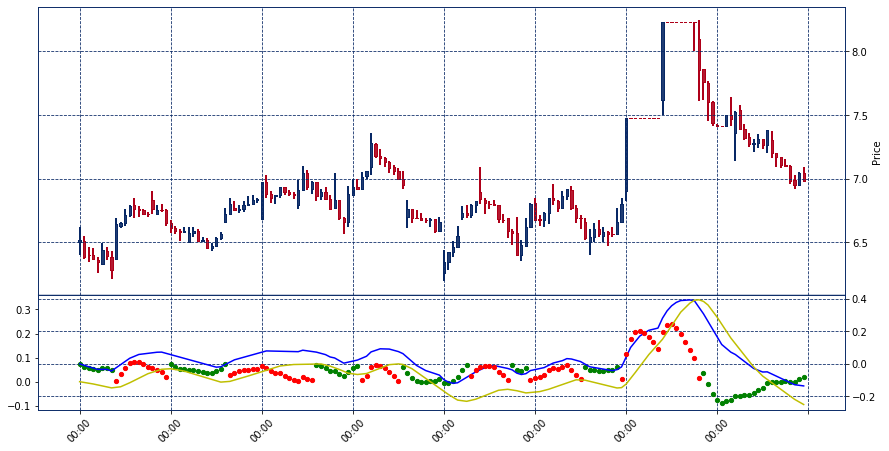

In [28]:
#Calculate MACD
def cal_macd_system(data,short_,long_,m):
    '''
    data=['Open','High','Low','Close','Volume']
    parameter: short_,long_,m
    return:data=['Open','High','Low','Close','Volume','diff','dea','macd']
    '''
    data['diff']=data['Close'].ewm(adjust=False,alpha=2/(short_+1),ignore_na=True).mean()-\
                data['Close'].ewm(adjust=False,alpha=2/(long_+1),ignore_na=True).mean()
    data['dea']=data['diff'].ewm(adjust=False,alpha=2/(m+1),ignore_na=True).mean()
    data['macd']=2*(data['diff']-data['dea'])
    return data
def macd_zero(macd):
    pos_signal, neg_signal = [],[]
    for idx,value in macd.iteritems():
        if value > 0:
            pos_signal.append(value)
            neg_signal.append(np.nan)
        else:
            neg_signal.append(value)
            pos_signal.append(np.nan)
    return pos_signal,neg_signal

#http://baostock.com/baostock/index.php/Python_API
#generate market chart
lg = bs.login() #login
#read stocks information
df_stocks = pro.stock_basic(exchange='', list_status='L', fields='symbol,name')
#read k data
fields= "Date,Code,Open,High,Low,Close,Volume"
today  = (datetime.datetime.now()+datetime.timedelta(hours=8)).strftime('%Y%m%d')#UTC->CTS +8hours
#today =datetime.datetime.now().strftime('%Y%m%d') 
df_cal = pro.trade_cal(exchange='', start_date='20200101', end_date=today)
df_cal =df_cal[df_cal['is_open']==1].reset_index(drop=True)
edate = df_cal[-21:][-1:]['cal_date'].tolist()[0] #last-1
sdate = df_cal[-21:].head(1)['cal_date'].tolist()[0] #first
edate = datetime.datetime.strptime(edate, '%Y%m%d').strftime('%Y-%m-%d') #turn to datetime
sdate = datetime.datetime.strptime(sdate, '%Y%m%d').strftime('%Y-%m-%d')  #turn to datetime
for code in df_stocks['symbol'].tolist():
    if code[0]=='6': code = 'sh.'+ code
    elif code[0]=='0' or code[0]=='3': code = 'sz.'+ code
    else: continue
    #read transaction data
    rs = bs.query_history_k_data(code=code, fields=fields, \
                                 start_date=sdate, end_date=edate, \
                                 frequency="30",adjustflag="3") #40days，one k line per 60 minutes
    data_list = []
    while (rs.error_code == '0') & rs.next():
        data_list.append(rs.get_row_data())
    result = pd.DataFrame(data_list, columns=rs.fields)
    result=result.apply(pd.to_numeric, errors='ignore')
    if result.shape[0] ==160:
        #plot K line 
        result = result[['Open','High','Low','Close','Volume']]
        result.index=pd.to_datetime(result.index)#turn index to datatime
        result = cal_macd_system(result,12,26,9)
        pos_macd, neg_macd  = macd_zero(result['macd']) 
        apds = [ mpf.make_addplot(result['diff'],panel='lower',color='b'),
                     mpf.make_addplot(result['dea'],panel='lower',color='y'),
                     mpf.make_addplot(pos_macd,panel='lower',color='r',scatter=True),
                     mpf.make_addplot(neg_macd,panel='lower',color='g',scatter=True)
                   ]
        kwargs = dict(type='candle',figratio =(16,8),volume=False,figscale=1)#line，mav=(5,10)
        Kline_path ='/data/fjsdata/qtsys/img/'+code+'-'+today+'.png'
        save = dict(fname=Kline_path,dpi=100, pad_inches=0.2)
        mpf.plot(result,**kwargs,addplot=apds,style='sas',savefig=save)#charles
        plt.close()
        Kline_img = cv2.resize(cv2.imread(Kline_path).astype(np.float32), (256, 256)) #read image 
        teI = []
        teI.append(Kline_img)
        #output feature with model
        teI = torch.from_numpy(np.array(teI)).type(torch.FloatTensor).cuda()
        teI = best_net(teI.permute(0, 3, 1, 2))#forword
        teI = torch.tanh(teI) #[-1,1]
        teI = teI.cpu().data.numpy().tolist()
        #retrieve from DB
        #np.linalg.norm(vec1 - vec2) #consine l2-norm 
        scores, neighbors = gpu_index.search(np.ascontiguousarray(teI, dtype=np.float32), k=1) #return top1
        if scores.flatten()[0]< 0.001: #similarity for sell
            label = trY[neighbors.flatten()[0]] 
            name = trN[neighbors.flatten()[0]]
            with open('/data/fjsdata/qtsys/label.csv','a+') as f:
                csv_write = csv.writer(f)
                if label == 1:
                    print('%s-S<-->%s'%(code+'-'+today+'.png',name))
                    csv_write.writerow([code+'-'+today+'.png','S'])
                elif (label == 0 and scores.flatten()[0]< 0.001): #similarity for buy
                    print('%s-B<-->%s'%(code+'-'+today+'.png',name))
                    csv_write.writerow([code+'-'+today+'.png','B'])          
                else:os.remove(Kline_path) #remove the image file if no handle
        else: os.remove(Kline_path) #remove the image file if no handle 
    else: pass #print('Error in collecting data:%s' % (code))
bs.logout()#logout

Org data dimension is 36.Embedded data dimension is 2


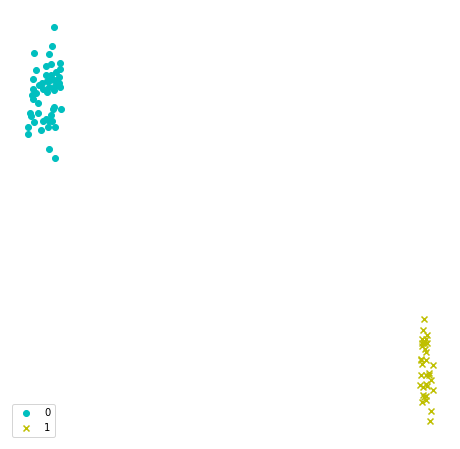

In [15]:
#visualize : t-SNE
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import random
def scatter(X, y):
    #X,y:numpy-array
    classes = len(list(set(y.tolist())))#get number of classes
    #palette = np.array(sns.color_palette("hls", classes))# choose a color palette with seaborn.
    color = ['c','y','m','b','g','r']
    marker = ['o','x','+','*','s']
    plt.figure(figsize=(8,8))#create a plot
    for i in range(classes):
        plt.scatter(X[y == i,0], X[y == i,1], c=color[i], marker=marker[i], label=str(i))
    plt.axis('off')
    plt.legend(loc='lower left')
    #plt.savefig('digits_tsne-generated.png', dpi=100)
    plt.show()

#prepare data，classes=2
idx= np.where(np.array(teY)==0)[0].tolist()
X0= np.array(trF)[idx]
y0= np.array(trY)[idx]

idx= np.where(np.array(teY)==1)[0].tolist()
X1= np.array(trF)[idx]
y1= np.array(trY)[idx]

y = np.append(y0,y1)
X = np.vstack((X0,X1))
#training t-sne 
tsne = TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(X)
print("Org data dimension is {}.Embedded data dimension is {}".format(X.shape[-1], X_tsne.shape[-1]))

#visualize
scatter(X_tsne, y)

In [10]:
#Generate Dataset
root_dir = '/data/fjsdata/qtsys/img/' #the path of images
data = pd.read_csv('/data/fjsdata/qtsys/label.csv') 
data = data.drop_duplicates()
data = data.sample(frac=1).reset_index(drop=True) #shuffle
#Dataset
X, Y = [],[]
for _, row in data.iterrows():
    try:
        image_path = os.path.join(root_dir, row['name'])
        img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(1600,800,3)->(256,256,3)
        X.append(img)
        if row['label']=='B':
            Y.append(0) #buy
        else:# row['label']=='S':
            Y.append(1) #sell
    except:
        print(iname+":"+str(image_path))
    sys.stdout.write('\r{} / {} '.format(len(Y),data.shape[0]))
    sys.stdout.flush()
#split trainset and testset 
trI, teI, trY, teY = train_test_split(X, Y, test_size=0.1, random_state=42) #list after return
print('The length of train set is %d'%len(trI))
print('The length of test set is %d'%len(teI))
    
#define model: ASH
class SpatialAttention(nn.Module):#spatial attention layer
    def __init__(self):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size=3, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.downsample_layer = None
        self.do_downsample = False
        if in_channels != out_channels or stride != 1:
            self.do_downsample = True
            self.downsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.do_downsample:
            identity = self.downsample_layer(x)

        return F.relu(out + identity, inplace=True)

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class ASHNet(nn.Module):
    def __init__(self, code_size: int):
        super().__init__()
        #Resnet
        self.net = nn.Sequential(
            ResBlock(in_channels=3, out_channels=16),
            ResBlock(in_channels=16, out_channels=16),
            ResBlock(in_channels=16, out_channels=16, stride=2),
        ) 
        #Attention 
        self.sa = SpatialAttention() 
        #fully connected
        self.linear = nn.Sequential(
            #nn.Linear(16*128*128, 4096),
            #nn.ReLU(inplace=True),
            nn.Linear(16*128*128, code_size),
            #nn.ReLU(inplace=True) #nn.Tanh()#[-1,1]
        )
        
        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        x = self.net(x)
        x = self.sa(x)*x
        x = x.view(x.size(0),-1)
        x = self.linear(x)
        return x

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)

#define loss function:pairwise loss            
class HashLossFunc(nn.Module):
    def __init__(self, margin=0.5, alpha=0.01):
        super(HashLossFunc, self).__init__()
        self.alpha = alpha #regularization
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
        self.l1_loss = nn.L1Loss(reduction='mean')
    
    def forward(self,h1,h2,y):    
        margin_val = self.margin * h1.shape[1]
        squared_loss = torch.mean(self.mse_loss(h1, h2), dim=1)
        # T1: 0.5 * (1 - y) * dist(x1, x2)
        positive_pair_loss = (0.5 * (1 - y) * squared_loss)
        mean_positive_pair_loss = torch.mean(positive_pair_loss)
        # T2: 0.5 * y * max(margin - dist(x1, x2), 0)
        zeros = torch.zeros_like(squared_loss)
        marginMat = margin_val * torch.ones_like(squared_loss)
        negative_pair_loss = 0.5 * y * torch.max(zeros, marginMat - squared_loss)
        mean_negative_pair_loss = torch.mean(negative_pair_loss)

        # T3: alpha(dst_l1(abs(x1), 1)) + dist_l1(abs(x2), 1)))
        mean_value_regularization = self.alpha * (
                self.l1_loss(torch.abs(h1), torch.ones_like(h1)) +
                self.l1_loss(torch.abs(h2), torch.ones_like(h2)))

        loss = mean_positive_pair_loss + mean_negative_pair_loss + mean_value_regularization
        return loss


#Generate image pairs for model
def onlineGenImgPairs():
    if (len(trY) % 2) == 0: spls = len(trY)
    else:  spls = len(trY)-1
    idx_sf = random.sample(range(0, spls),spls)
    trI1_sf, trI2_sf, trY1_sf, trY2_sf = [],[],[],[]
    flag = 0
    for i in idx_sf:
        if flag==0:
            trI1_sf.append(trI[i])
            trY1_sf.append(trY[i])
            flag =1
        else:
            trI2_sf.append(trI[i])
            trY2_sf.append(trY[i])
            flag =0
    trY_sf = np.where((np.array(trY1_sf)-np.array(trY2_sf))!=0,1,0)
    return np.array(trI1_sf),np.array(trI2_sf),trY_sf


#define model
hash_size=36
model = ASHNet(code_size=hash_size).cuda()
criterion  = HashLossFunc(margin=0.5).cuda() #define loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(10):#iteration
    trI1_sf, trI2_sf, trY_sf = onlineGenImgPairs()
    losses = []
    num_batches = len(trY_sf) // batchSize +1
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY_sf), (i+1)*batchSize])
        I1_batch = torch.from_numpy(trI1_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        I2_batch = torch.from_numpy(trI2_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Y_batch = torch.from_numpy(trY_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        #forword
        X1_batch = model(I1_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        X2_batch = model(I2_batch.permute(0, 3, 1, 2))
        #binary-like loss
        loss = criterion(X1_batch,X2_batch,Y_batch)
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
loss=loss.cpu()
torch.cuda.empty_cache()
#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize +1
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    #X_batch = torch.sign(torch.tanh(X_batch))
    X_batch = torch.tanh(X_batch)
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teF = []
num_batches = len(teI) // batchSize + 1
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(teI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    #X_batch = torch.sign(torch.tanh(X_batch))
    X_batch = torch.tanh(X_batch)
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    teF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(hash_size) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
#performance
scores, neighbors = gpu_index.search(np.ascontiguousarray(teF, dtype=np.float32), k=1) #return top1
y_pred = []
for i in neighbors.flatten():
    y_pred.append(np.array(trY)[i]) #label of top1
print ( 'Accuracy: %.6f'%accuracy_score(teY, y_pred))
#confusion matrix
labels = list(set(teY))
cm = confusion_matrix(teY, y_pred, labels=labels ) #labels=[B,S]
print (cm)
print ('Sensitivity of B: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of S: %.6f'%float(cm[1][1]/np.sum(cm[1])))

for topk in [10]:#[5,10,15,20]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    for i, teVal in enumerate(teF):
        stype = teY[i]
        scores, neighbors = gpu_index.search(np.array(teF)[i:i+1].astype('float32'), k=topk)
        #map_item_score = {}
        #for j, trVal in enumerate(trF):
        #    map_item_score[j] = pdist(np.vstack([teVal,trVal]),'hamming')
        #ranklist = heapq.nsmallest(topk, map_item_score, key=map_item_score.get)
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        #for j in ranklist:
        for j in neighbors.flatten():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))

850 / 850 The length of train set is 765
The length of test set is 85
 39 / 39 : loss = 0.065036Eopch:     1 mean_loss = 1.422379
 39 / 39 : loss = 0.086033Eopch:     2 mean_loss = 1.027365
 39 / 39 : loss = 0.034579Eopch:     3 mean_loss = 0.423771
 39 / 39 : loss = 0.053811Eopch:     4 mean_loss = 0.241761
 39 / 39 : loss = 2.826695Eopch:     5 mean_loss = 0.308919
 39 / 39 : loss = 0.038412Eopch:     6 mean_loss = 0.308893
 39 / 39 : loss = 0.210814Eopch:     7 mean_loss = 0.176090
 39 / 39 : loss = 0.039367Eopch:     8 mean_loss = 0.127167
 39 / 39 : loss = 0.028646Eopch:     9 mean_loss = 0.104719
 39 / 39 : loss = 0.036144Eopch:    10 mean_loss = 0.088281
best_loss = 0.088281
 8 / 9 7 Completed buliding index in 1 seconds
Accuracy: 1.000000
[[58  0]
 [ 0 27]]
Sensitivity of B: 1.000000
Sensitivity of S: 1.000000
mHR@10=0.995294, mAP@10=0.994471, mRR@10=1.000000


In [9]:
#Generate Dataset
root_dir = '/data/fjsdata/qtsys/img/' #the path of images
data = pd.read_csv('/data/fjsdata/qtsys/label.csv') 
data = data.drop_duplicates()
data = data.sample(frac=1).reset_index(drop=True) #shuffle
#Dataset
X, Y = [],[]
for _, row in data.iterrows():
    try:
        image_path = os.path.join(root_dir, row['name'])
        img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(1600,800,3)->(256,256,3)
        X.append(img)
        if row['label']=='B':
            Y.append(0) #buy
        else:# row['label']=='S':
            Y.append(1) #sell
    except:
        print(iname+":"+str(image_path))
    sys.stdout.write('\r{} / {} '.format(len(Y),data.shape[0]))
    sys.stdout.flush()
#split trainset and testset 
trI, teI, trY, teY = train_test_split(X, Y, test_size=0.1, random_state=42) #list after return
print('The length of train set is %d'%len(trI))
print('The length of test set is %d'%len(teI))
    
#define model: ASH
class SpatialAttention(nn.Module):#spatial attention layer
    def __init__(self):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size=3, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.downsample_layer = None
        self.do_downsample = False
        if in_channels != out_channels or stride != 1:
            self.do_downsample = True
            self.downsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.do_downsample:
            identity = self.downsample_layer(x)

        return F.relu(out + identity, inplace=True) #resnet

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class ATHNet(nn.Module):
    def __init__(self, code_size: int):
        super().__init__()
        #resnet and maxpool
        self.net1 = nn.Sequential(#(3,256,256)->(16,128,128)
            ResBlock(in_channels=3, out_channels=16, stride=2), 
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1)
        )
        
        #Attention (16,128,128)->(16,128,128)
        self.sa = SpatialAttention()
        
        #resnet and meanpool
        self.net2 =nn.Sequential( #(16,128,128)->(8,64,64)
            ResBlock(in_channels=16, out_channels=8, stride=2),
            nn.AvgPool2d(kernel_size=3, padding=1, stride=1)
        ) 
         
        #fully connected with conv (8,64,64)->(1,32,32)
        self.dense=ResBlock(in_channels=8, out_channels=1, stride=2)
        #fully connected (1,32,32)->class_size
        self.linear = nn.Linear(1*32*32, code_size)
    
        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        x = self.net1(x)
        x = self.sa(x)*x
        x = self.net2(x)
        x = self.dense(x)
        x = x.view(x.size(0),-1)
        x = self.linear(x)
        return x

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)

#define loss function:pairwise loss            
class HashLossFunc(nn.Module):
    def __init__(self, margin=0.5, alpha=0.01):
        super(HashLossFunc, self).__init__()
        self.alpha = alpha #regularization
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
        self.l1_loss = nn.L1Loss(reduction='mean')
    
    def forward(self,h1,h2,y):    
        margin_val = self.margin * h1.shape[1]
        squared_loss = torch.mean(self.mse_loss(h1, h2), dim=1)
        # T1: 0.5 * (1 - y) * dist(x1, x2)
        positive_pair_loss = (0.5 * (1 - y) * squared_loss)
        mean_positive_pair_loss = torch.mean(positive_pair_loss)
        # T2: 0.5 * y * max(margin - dist(x1, x2), 0)
        zeros = torch.zeros_like(squared_loss)
        marginMat = margin_val * torch.ones_like(squared_loss)
        negative_pair_loss = 0.5 * y * torch.max(zeros, marginMat - squared_loss)
        mean_negative_pair_loss = torch.mean(negative_pair_loss)

        # T3: alpha(dst_l1(abs(x1), 1)) + dist_l1(abs(x2), 1)))
        mean_value_regularization = self.alpha * (
                self.l1_loss(torch.abs(h1), torch.ones_like(h1)) +
                self.l1_loss(torch.abs(h2), torch.ones_like(h2)))

        loss = mean_positive_pair_loss + mean_negative_pair_loss + mean_value_regularization
        return loss


#Generate image pairs for model
def onlineGenImgPairs():
    if (len(trY) % 2) == 0: spls = len(trY)
    else:  spls = len(trY)-1
    idx_sf = random.sample(range(0, spls),spls)
    trI1_sf, trI2_sf, trY1_sf, trY2_sf = [],[],[],[]
    flag = 0
    for i in idx_sf:
        if flag==0:
            trI1_sf.append(trI[i])
            trY1_sf.append(trY[i])
            flag =1
        else:
            trI2_sf.append(trI[i])
            trY2_sf.append(trY[i])
            flag =0
    trY_sf = np.where((np.array(trY1_sf)-np.array(trY2_sf))!=0,1,0)
    return np.array(trI1_sf),np.array(trI2_sf),trY_sf


#define model
hash_size=36
model = ATHNet(code_size=hash_size).cuda()
criterion  = HashLossFunc(margin=0.5).cuda() #define loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(10):#iteration
    trI1_sf, trI2_sf, trY_sf = onlineGenImgPairs()
    losses = []
    num_batches = len(trY_sf) // batchSize +1
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY_sf), (i+1)*batchSize])
        I1_batch = torch.from_numpy(trI1_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        I2_batch = torch.from_numpy(trI2_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Y_batch = torch.from_numpy(trY_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        #forword
        X1_batch = model(I1_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        X2_batch = model(I2_batch.permute(0, 3, 1, 2))
        #binary-like loss
        loss = criterion(X1_batch,X2_batch,Y_batch)
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
loss=loss.cpu()
torch.cuda.empty_cache()
#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize +1
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    #X_batch = torch.sign(torch.tanh(X_batch))
    X_batch = torch.tanh(X_batch)
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teF = []
num_batches = len(teI) // batchSize + 1
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(teI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    #X_batch = torch.sign(torch.tanh(X_batch))
    X_batch = torch.tanh(X_batch)
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    teF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(hash_size) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
#performance
scores, neighbors = gpu_index.search(np.ascontiguousarray(teF, dtype=np.float32), k=1) #return top1
y_pred = []
for i in neighbors.flatten():
    y_pred.append(np.array(trY)[i]) #label of top1
print ( 'Accuracy: %.6f'%accuracy_score(teY, y_pred))
#confusion matrix
labels = list(set(teY))
cm = confusion_matrix(teY, y_pred, labels=labels ) #labels=[B,S]
print (cm)
print ('Sensitivity of B: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of S: %.6f'%float(cm[1][1]/np.sum(cm[1])))
for topk in [10]:#[5,10,15,20]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    for i, teVal in enumerate(teF):
        stype = teY[i]
        map_item_score = {}
        for j, trVal in enumerate(trF):
            map_item_score[j] = pdist(np.vstack([teVal,trVal]),'cosine')
        ranklist = heapq.nsmallest(topk, map_item_score, key=map_item_score.get)
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        for j in ranklist:
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))

850 / 850 The length of train set is 765
The length of test set is 85
 39 / 39 : loss = 4.486623Eopch:     1 mean_loss = 4.318382
 39 / 39 : loss = 1.045279Eopch:     2 mean_loss = 2.624930
 39 / 39 : loss = 1.491477Eopch:     3 mean_loss = 0.547569
 39 / 39 : loss = 0.039266Eopch:     4 mean_loss = 0.411702
 39 / 39 : loss = 0.036401Eopch:     5 mean_loss = 0.334284
 39 / 39 : loss = 0.044971Eopch:     6 mean_loss = 0.319785
 39 / 39 : loss = 0.107745Eopch:     7 mean_loss = 0.326193
 39 / 39 : loss = 0.031921Eopch:     8 mean_loss = 0.320163
 39 / 39 : loss = 0.079289Eopch:     9 mean_loss = 0.311246
 39 / 39 : loss = 0.062247Eopch:    10 mean_loss = 0.291225
best_loss = 0.291225
 8 / 9 7 Completed buliding index in 1 seconds
Accuracy: 0.988235
[[55  1]
 [ 0 29]]
Sensitivity of B: 0.982143
Sensitivity of S: 1.000000
mHR@10=0.961176, mAP@10=0.949074, mRR@10=0.982353


In [8]:
print(edate)
print(sdate)
print(today)

2020-03-26
2020-02-27
20200326
